# Creating a playing cards dataset
This notebook is a guide through the creation of a dataset of playing cards. The cards are labeled with their name (ex: "2c" for "2 of spades", "Kh" for King for hearts) and with the bounding boxes delimiting their printed corners.
> _Why bounding boxes around the corners, and not around the whole card ?_<br>Because in real conditions, more often than not, cards are partially covered. And the corner of a card is the minimum information you need to identify it.

This dataset can be used for the training of a neural net intended to detect/localize playing cards. It was used on the project __[Playing card detection with YOLO v3](https://youtu.be/pnntrewH0xg)__


# Prerequisites 

### A. In addition to opencv and numpy, you need the following python packages :
1. **imgaug** : https://github.com/aleju/imgaug 
> Helps with image augmentation
2. **shapely** : https://github.com/Toblerity/Shapely
> For the manipulation and analysis of geometric objects in the Cartesian plane. It is useful here when we want to check if the bounding box of a card corner is covered by another card
3. **tqdm** : https://github.com/tqdm/tqdm
> A progress bar tool. Not mandatory but convenient when you generate thousands of images

### B. Get the Describable Textures Dataset (DTD)
> A collection of textural images in the wild (https://www.robots.ox.ac.uk/~vgg/data/dtd/). It is probably not its original goal, but it is used here as an easy way to generate various backgrounds for our images.

### C. A real deck of cards
> This the only physical "data" you need. You have to make some measurements on the cards, and to take a picture/shoot a movie of each of the 52 cards of the deck. Everything else will be generated by scripts.


#### C.1 Measurements on the cards
Use a ruler to measure the dimensions as indicated in the image below. 
For the corner* measures, the idea is to delimit one rectangular zone that can hold every value+suit. The size of the marks may vary with the value or the suit, so take the measures on the cards with the widest, the tallest symbols, and add one or two millimeters. 
<img src="img/measures.png" alt="Measures" title="" />
Report the measures in mm in the cell below (and don't forget to run the cell).

In [84]:
class Deck(object):
    def __init__(self, data):
        [self.cardW, self.cardH, self.cornerXmin, self.cornerXmax, self.cornerYmin, self.cornerYmax, self.corners] = data
        
        # We convert the measures from mm to pixels: multiply by an arbitrary factor 'zoom'
        # You shouldn't need to change this
        zoom = 4
        self.cardW = int(self.cardW * zoom)
        self.cardH = int(self.cardH * zoom)
        self.cornerXmin = int(self.cornerXmin * zoom)
        self.cornerXmax = int(self.cornerXmax * zoom)
        self.cornerYmin = int(self.cornerYmin * zoom)
        self.cornerYmax = int(self.cornerYmax * zoom)
    
    def __str__(self):
        return ' '.join([
            '<Deck',
            'width:{}'.format(self.cardW),
            'height:{}'.format(self.cardH),
            'x:[{} - {}]px'.format(self.cornerXmin, self.cornerXmax),
            'y:[{} - {}]px'.format(self.cornerYmin, self.cornerYmax),
            'corners:{}'.format(self.corners),
            '>'
        ])
        
decks = {
    'music': Deck([57, 89, 3, 10.3, 3.2, 23.8, 4]),
    'WWI': Deck([62.5, 88, 1.8, 9, 3.5, 22.5, 2]),
    'green_bike': Deck([62, 88, 1.5, 9.2, 3, 23.5, 2]),
    'iceland': Deck([56, 86, 1.5, 10, 3.5, 24.5, 4]),
    'venice': Deck([61, 92, 2.5, 10.8, 3.5, 22, 4]),
    # Not working
    'code': Deck([57, 84, 3, 10, 3, 16, 2]),
    'planes': Deck([62.5, 88, 3, 9.5, 4, 21, 2]),
}

## Imports

In [2]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from glob import glob 
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon
import re

## Some convenient functions used in this notebook

In [3]:

def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    for polygon in polygons:
        # An polygon has either shape (n,2), 
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape)==3:
            polygon=polygon.reshape(-1,2)
        patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(patch)

def give_me_filename(dirname, suffixes, prefix=""):
    """
        Function that returns a filename or a list of filenames in directory 'dirname'
        that does not exist yet. If 'suffixes' is a list, one filename per suffix in 'suffixes':
        filename = dirname + "/" + prefix + random number + "." + suffix
        Same random number for all the file name
        Ex: 
        > give_me_filename("dir","jpg", prefix="prefix")
        'dir/prefix408290659.jpg'
        > give_me_filename("dir",["jpg","xml"])
        ['dir/877739594.jpg', 'dir/877739594.xml']        
    """
    if not isinstance(suffixes, list):
        suffixes=[suffixes]
    
    suffixes=[p if p[0]=='.' else '.'+p for p in suffixes]
          
    while True:
        bname="%09d"%random.randint(0,999999999)
        fnames=[]
        for suffix in suffixes:
            fname=os.path.join(dirname,prefix+bname+suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)
                
        if len(fnames) == len(suffixes): break
    
    if len(fnames)==1:
        return fnames[0]
    else:
        return fnames

# Define global variables

In [4]:
data_dir="data" # Directory that will contain all kinds of data (the data we download and the data we generate)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

card_suits=['s','h','d','c']
card_values=['a','k','q','j','t','9','8','7','6','5','4','3','2']

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir+"/backgrounds.pck"

# Pickle file containing the card images
cards_pck_fn=data_dir+"/cards.pck"


# imgW,imgH: dimensions of the generated dataset images 
imgW=720
imgH=720

class RefCard(object):
    def __init__(self, deck):
        cardW = deck.cardW
        cardH = deck.cardH
        cornerXmin = deck.cornerXmin
        cornerXmax = deck.cornerXmax
        cornerYmin = deck.cornerYmin
        cornerYmax = deck.cornerYmax

        self.card = np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
        self.rot = np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
        self.hl = np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
        self.hr = np.array([[cardW-cornerXmax,cornerYmin],[cardW-cornerXmin,cornerYmin],[cardW-cornerXmin,cornerYmax],[cardW-cornerXmax,cornerYmax]],dtype=np.float32)
        self.lr = np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
        self.ll = np.array([[cornerXmin,cardH-cornerYmax],[cornerXmax,cardH-cornerYmax],[cornerXmax,cardH-cornerYmin],[cornerXmin,cardH-cornerYmin]],dtype=np.float32)
        if deck.corners == 4:
            self.cornersArray = [self.hl, self.hr, self.ll, self.lr]
        elif deck.corners == 2:
            self.cornersArray = [self.hl, self.lr]
        else:
            raise Exception("I can't do {} corners".format(deck.corners))
        self.cornersNP = np.array(self.cornersArray)


### Load the backgounds pickle file in 'backgrounds'
'backgrounds' is an instance of the class Backgrounds
To get a random background image, call the method : backgrounds.get_random

In [5]:
class Backgrounds():
    def __init__(self,backgrounds_pck_fn=backgrounds_pck_fn):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Nb of images loaded :", self._nb_images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg
    
backgrounds = Backgrounds()


Nb of images loaded : 5640


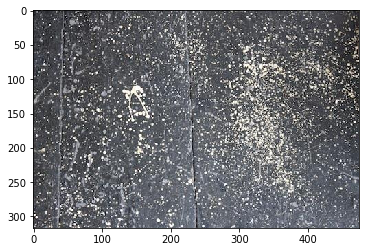

In [6]:
# Test: display a random background
_=backgrounds.get_random(display=True)

# Extraction of the cards from pictures or video 

### Define the alphamask
The alphamask has 2 purposes:
- clean the border of the detected cards,
- make that border transparent. Cards are not perfect rectangles because corners are rounded. We need to make transparent the zone between the real card and its bounding rectangle, otherwise this zone will be visible in the final generated images of the dataset


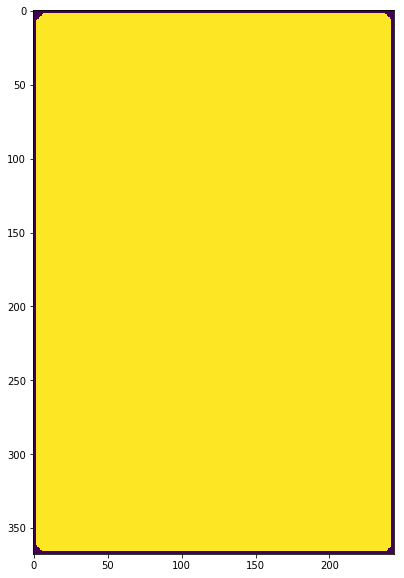

In [23]:
deck_name = 'venice'

def get_alpha_mask(deck):
    bord_size=2 # bord_size alpha=0
    alphamask=np.ones((deck.cardH, deck.cardW), dtype=np.uint8)*255
    cv2.rectangle(alphamask, (0,0), (deck.cardW-1, deck.cardH-1), 0, bord_size)
    cv2.line(alphamask, (bord_size*3,0), (0,bord_size*3), 0, bord_size)
    cv2.line(alphamask, (deck.cardW-bord_size*3,0),(deck.cardW, bord_size*3), 0, bord_size)
    cv2.line(alphamask, (0,deck.cardH-bord_size*3),(bord_size*3, deck.cardH),0,bord_size)
    cv2.line(alphamask, (deck.cardW-bord_size*3,deck.cardH),(deck.cardW, deck.cardH-bord_size*3),0,bord_size)
    return alphamask

alphamask = get_alpha_mask(decks[deck_name])
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

## Function extract_card 
Extract from scene image (cv2/bgr) the part corresponding to the card and transforms it 
to fit into the reference card shape.
We suppose here that the user facilitates as much as he can the extraction task by
making the scene image simple (one card on uniform backgroung, not too blurry, correct lighting,...)

In [8]:
def varianceOfLaplacian(img):
    """
    Compute the Laplacian of the image and then return the focus
    measure, which is simply the variance of the Laplacian
    Source: A.Rosebrock, https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    """
    return cv2.Laplacian(img, cv2.CV_64F).var()

def increase_contrast(img, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(img, table)

def extract_card(deck, img, output_fn=None, min_focus=120, debug=False, contrast=1):
    """
    """
    
    high_contrast = increase_contrast(img, contrast)
    
    imgwarp=None
    
    # Check the image is not too blurry
    focus=varianceOfLaplacian(img)
    if focus < min_focus: 
        if debug: print("Focus too low :", focus)
        return False,None
    
    # Convert in gray color
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(high_contrast, cv2.COLOR_BGR2GRAY)
    # gray = high_contrast
    
    # Noise-reducing and edge-preserving filter
    gray=cv2.bilateralFilter(gray,11,17,17)
    
    # Edge extraction
    edge=cv2.Canny(gray,30,200)
    
    # Find the contours in the edged image
    _,cnts, _ = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # We suppose that the contour with largest area corresponds to the contour delimiting the card
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    
    # We want to check that 'cnt' is the contour of a rectangular shape
    # First, determine 'box', the minimum area bounding rectangle of 'cnt'
    # Then compare area of 'cnt' and area of 'box'
    # Both areas sould be very close
    rect=cv2.minAreaRect(cnt)
    box=cv2.boxPoints(rect)
    box=np.int0(box)
    areaCnt=cv2.contourArea(cnt)
    areaBox=cv2.contourArea(box)
    valid=areaCnt/areaBox>0.95
    
    refCard = RefCard(deck)
    
    if valid:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar)=rect
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr > hr:
            Mp=cv2.getPerspectiveTransform(np.float32(box), refCard.card)
        else:
            Mp=cv2.getPerspectiveTransform(np.float32(box), refCard.rot)
        # Determine the warped image by applying the transformation to the image
        imgwarp=cv2.warpPerspective(img, Mp, (deck.cardW, deck.cardH))
        # Add alpha layer
        imgwarp=cv2.cvtColor(imgwarp, cv2.COLOR_BGR2BGRA)
        
        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta=cnt.reshape(1,-1,2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp=cv2.perspectiveTransform(cnta, Mp)
        cntwarp=cntwarp.astype(np.int)
        
        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel=np.zeros(imgwarp.shape[:2],dtype=np.uint8)
        # Then fill in the contour to make opaque this zone of the card 
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)
        
        # Apply the alphamask onto the alpha channel to clean it
        alphamask = get_alpha_mask(deck)
        alphachannel=cv2.bitwise_and(alphachannel, alphamask)
        
        # Add the alphachannel to the warped image
        imgwarp[:,:,3] = alphachannel
        
        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn, imgwarp)
        
    if debug:
        cv2.imshow("Gray",gray)
        cv2.imshow("Canny",edge)
        edge_bgr=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
        cv2.drawContours(edge_bgr,[box],0,(0,0,255),3)
        cv2.drawContours(edge_bgr,[cnt],0,(0,255,0),-1)
        cv2.imshow("Contour with biggest area",edge_bgr)
        if valid:
            cv2.imshow("Alphachannel",alphachannel)
            cv2.imshow("Extracted card",imgwarp)

    return valid, imgwarp

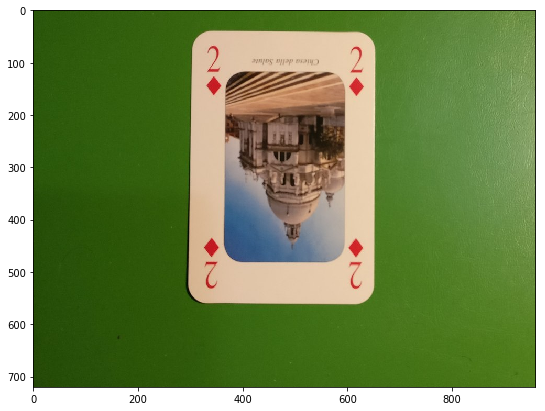

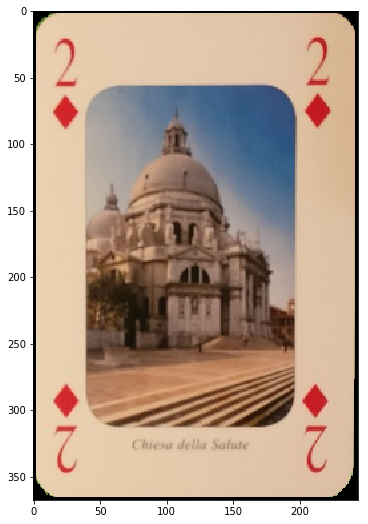

In [24]:
# Test on one image
debug=True
img_name = "data/import/2d.jpg"
deck_name = 'venice'

img=cv2.imread(img_name)
display_img(img)
valid,card=extract_card(decks[deck_name], img, "test/extracted.jpg", debug=debug, min_focus=0, contrast=1.5)
if valid:
    display_img(card)
if debug:
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Card extraction from all the images

In [25]:
import_dir = "data/import"
imgs_dir = "data/cards"
deck_name = "venice"

deck = decks[deck_name]
for suit in card_suits:
    for value in card_values:
        card_name=value+suit
        
        output_dir = os.path.join(imgs_dir, card_name)
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        
        img_name = os.path.join(import_dir, card_name + '.jpg')
        output = os.path.join(output_dir, deck_name + '.jpg')

        img=cv2.imread(img_name)
        valid, _ = extract_card(deck, img, output, min_focus=0, contrast=1.5)
        if valid:
            print("Extracted image for %s" % card_name)
        else:
            print("Failed to extract image for %s" % card_name)

Extracted image for as
Extracted image for ks
Extracted image for qs
Extracted image for js
Extracted image for ts
Extracted image for 9s
Extracted image for 8s
Extracted image for 7s
Extracted image for 6s
Extracted image for 5s
Extracted image for 4s
Extracted image for 3s
Extracted image for 2s
Extracted image for ah
Extracted image for kh
Extracted image for qh
Extracted image for jh
Extracted image for th
Extracted image for 9h
Extracted image for 8h
Extracted image for 7h
Extracted image for 6h
Extracted image for 5h
Extracted image for 4h
Extracted image for 3h
Extracted image for 2h
Extracted image for ad
Extracted image for kd
Extracted image for qd
Extracted image for jd
Extracted image for td
Extracted image for 9d
Extracted image for 8d
Extracted image for 7d
Extracted image for 6d
Extracted image for 5d
Extracted image for 4d
Extracted image for 3d
Extracted image for 2d
Extracted image for ac
Extracted image for kc
Extracted image for qc
Extracted image for jc
Extracted i

### Before going on, check that everything looks good
We randomly choose and display one of the extracted card. We also draw on the card the 2 polygons defined by refCornerHL and refCornerLR. Check that the value and suit symbols are well inside the polygons. If not, check the hand-made measures : cardW, cardH, cornerXmin, cornerXmax, cornerYmin and cornerYmax


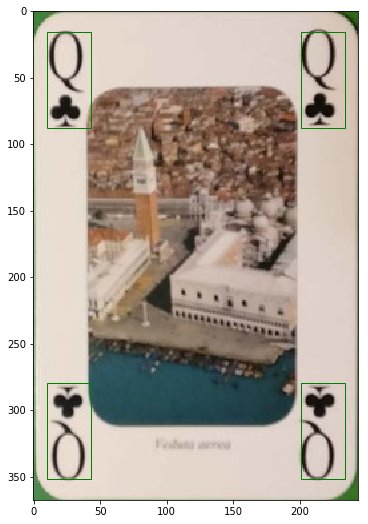

In [32]:
# Run a few times...
import_dir="data/import"
imgs_dir="data/cards"
deck_name = "venice"

refCard = RefCard(decks[deck_name])
imgs_fns=glob(imgs_dir + "/*/{}.jpg".format(deck_name))
img_fn=random.choice(imgs_fns)
display_img(cv2.imread(img_fn,cv2.IMREAD_UNCHANGED), polygons=refCard.cornersArray)

# Finding the convex hulls
<img src="img/convex_hull.jpg" alt="Convex hull" title="Convex hull" />
This function 'find_hull' finds the convex hull in one of the corner of a card image.
The convex hull is the minimal convex polygon that contains both the value and the suit symbols. 

When I wrote this function it needed a lot of tweaking to make it work. It works well with my deck of cards, but I can't guarantee it is adapted to other decks. Search for the keyword TWEAK in the comments to find the variable and values that may need some tweak. Some of them depend on the value of global variable 'zoom'.
It may happen that the function can't find a valid convex hull for a card. It is not a problem, it only means that this card won't be used to generate the dataset.

In [9]:
def findHull(deck, img, corner, debug=False):
    """
        Find in the zone 'corner' of image 'img' and return, the convex hull delimiting
        the value and suit symbols
        'corner' (shape (4,2)) is an array of 4 points delimiting a rectangular zone, 
        takes one of the 2 possible values : refCornerHL or refCornerLR
        debug=
    """
    
    kernel = np.ones((3,3),np.uint8)
    corner=corner.astype(np.int)

    # We will focus on the zone of 'img' delimited by 'corner'
    x1=int(corner[0][0])
    y1=int(corner[0][1])
    x2=int(corner[2][0])
    y2=int(corner[2][1])
    w=x2-x1
    h=y2-y1
    zone=img[y1:y2,x1:x2].copy()

    strange_cnt=np.zeros_like(zone)
    gray=cv2.cvtColor(zone,cv2.COLOR_BGR2GRAY)
    thld=cv2.Canny(gray,30,200)
    thld = cv2.dilate(thld,kernel,iterations=1)
    if debug: cv2.imshow("thld",thld)
    
    # Find the contours
    _,contours,_=cv2.findContours(thld.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    min_area=30 # We will reject contours with small area. TWEAK, 'zoom' dependant
    min_solidity=0.3 # Reject contours with a low solidity. TWEAK
    
    concat_contour=None # We will aggregate in 'concat_contour' the contours that we want to keep
    
    ok=True
    for c in contours:
        area=cv2.contourArea(c)

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        # Determine the center of gravity (cx,cy) of the contour
        M=cv2.moments(c)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        #  abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 : TWEAK, the idea here is to keep only the contours which are closed to the center of the zone
        if area >= min_area and abs(w/2-cx)<w*0.4 and abs(h/2-cy)<h*0.4 and solidity>min_solidity:
            if debug:
                cv2.drawContours(zone,[c],0,(255,0,0),-1)
            if concat_contour is None:
                concat_contour=c
            else:
                concat_contour=np.concatenate((concat_contour,c))
        if debug and solidity <= min_solidity :
            print("Solidity",solidity)
            cv2.drawContours(strange_cnt,[c],0,255,2)
            cv2.imshow("Strange contours",strange_cnt)
            
     
    if concat_contour is not None:
        # At this point, we suppose that 'concat_contour' contains only the contours corresponding the value and suit symbols   
        # We can now determine the hull
        hull=cv2.convexHull(concat_contour)
        hull_area=cv2.contourArea(hull)
        # If the area of the hull is to small or too big, there may be a problem
        min_hull_area=940 # TWEAK, deck and 'zoom' dependant
        max_hull_area=2120 # TWEAK, deck and 'zoom' dependant
        if hull_area < min_hull_area or hull_area > max_hull_area: 
            ok=False
            if debug!="no":
                print("Hull area=",hull_area,"too large or too small")
        # So far, the coordinates of the hull are relative to 'zone'
        # We need the coordinates relative to the image -> 'hull_in_img' 
        hull_in_img=hull+corner[0]

    else:
        ok=False
    
    
    if debug:
        if concat_contour is not None:
            cv2.drawContours(zone,[hull],0,(0,255,0),1)
            cv2.drawContours(img,[hull_in_img],0,(0,255,0),1)
        cv2.imshow("Zone",zone)
        cv2.imshow("Image",img)
        key=cv2.waitKey(0)
        if key==27:
            return None
    if not ok:
        return None
    
    return hull_in_img

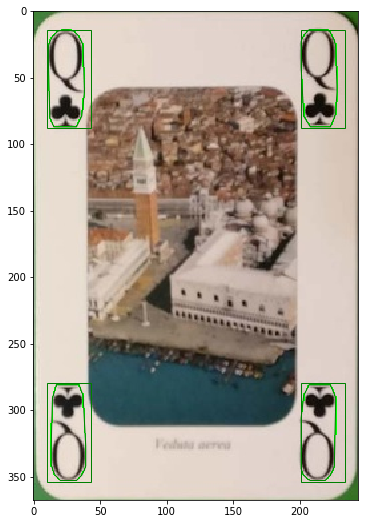

In [35]:
# Test find_hull on a random card image
# debug = "no" or "pause_always" or "pause_on_pb"
# If debug!="no", you may have to press a key to continue execution after pause
debug=True 
imgs_dir="data/cards"
deck_name = 'venice'

imgs_fns=glob('{}/qc/{}.jpg'.format(imgs_dir, deck_name))
img_fn=random.choice(imgs_fns)
img = cv2.imread(img_fn, cv2.IMREAD_UNCHANGED)

deck = decks[deck_name]
refCard = RefCard(deck)
hulls = []
for corner in refCard.cornersArray:
    hulls.append(findHull(deck, img, corner, debug=debug))

display_img(img, refCard.cornersArray + hulls)
if debug: cv2.destroyAllWindows()

### Load all card image, calculate their convex hulls and save the whole in a pickle file (1x)

The next times, we will directly load the pickle file 
The structure saved in the pickle file is a dictionnary named 'cards' of lists of triplets (img,hullHL,hullLR). The keys of the dictionnary are the card names ("Ad","10h",... so 52 entries in the dictionnary). 

In [36]:
deck_re = re.compile('([^/]*).jpg$')
cards={}
imgs_dir = 'data/cards'

for suit in card_suits:
    for value in card_values:
        card_name=value+suit        
        card_dir=os.path.join(imgs_dir,card_name)
        if not os.path.isdir(card_dir):
            print("!!! {} does not exist !!!".format(card_dir))
            continue
        cards[card_name]=[]
        for f in glob(card_dir + "/*.jpg"):
            deck_name = deck_re.search(f).group(1)
            img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
            refCard = RefCard(decks[deck_name])
            hulls = []
            for corner in refCard.cornersArray:
                hull = findHull(deck, img, corner, debug=False) 
                if hull is None:
                    hulls = []
                    break
                hulls.append(hull)
                     
            if not hulls:
                print("File {} not used.".format(f))
                continue
                
            # We store the image in "rgb" format (we don't need opencv anymore)
            img=cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
            cards[card_name].append((deck_name, img, hulls))



print("Saved in :",cards_pck_fn)
pickle.dump(cards,open(cards_pck_fn,'wb'))

cv2.destroyAllWindows()

Saved in : data/cards.pck


### Load the cards pickle file in 'cards'
'cards' is an instance of the class Cards
To get a random background image, call the method : cards.get_random() or cards.get_random(card_name) if you want a random card of a given value. Ex: cards.get_random('Ah')

In [82]:
class Card():
    def __init__(self, deck_name, img, name, hulls):
        self.deck = decks[deck_name]
        self.img = img
        self.name = name
        self.hulls = hulls
    
    def __str__(self):
        return '<Card deck:{} name:{}>'.format(self.deck, self.name, self.hulls)

class Cards():
    def __init__(self,cards_pck_fn=cards_pck_fn):
        self._cards=pickle.load(open(cards_pck_fn,'rb'))
        # self._cards is a dictionary where keys are card names (ex:'Kc') and values are lists of (img,hullHL,hullLR) 
        self._nb_cards_by_value={k:len(self._cards[k]) for k in self._cards}
        print("Nb of cards loaded per name :", self._nb_cards_by_value)
        
    def get_random(self, card_name=None, display=False):
        if card_name is None:
            card_name= random.choice(list(self._cards.keys()))
        deck_name, card_img, hulls=self._cards[card_name][random.randint(0,self._nb_cards_by_value[card_name]-1)]
        if display:
            if display: display_img(card_img, hulls, "rgb")
        return Card(deck_name, card_img, card_name, hulls)
    
cards = Cards()


Nb of cards loaded per name : {'qs': 5, 'ts': 5, '6h': 5, 'ac': 5, 'as': 5, '9d': 5, 'ad': 5, '8d': 5, '5h': 5, 'qh': 5, 'jc': 5, '4d': 5, 'js': 5, 'tc': 5, '6s': 5, '3h': 5, '8h': 5, '4c': 5, 'qd': 5, 'kh': 5, '7c': 5, '8c': 5, '2h': 5, '5c': 5, '6c': 5, '4h': 5, 'qc': 5, 'jh': 5, '7h': 5, '3d': 5, '8s': 5, '2s': 5, 'th': 5, '7s': 5, '2c': 5, '4s': 5, 'jd': 5, '9s': 5, 'kc': 5, '7d': 5, 'ah': 5, 'kd': 5, '3s': 5, '9c': 5, '3c': 5, '5d': 5, 'ks': 5, '5s': 5, '6d': 5, '9h': 5, 'td': 5, '2d': 5}


<Card deck:<Deck width:244 height:368 x:[10 - 43]px y:[14 - 88]px corners:4 > name:3d>


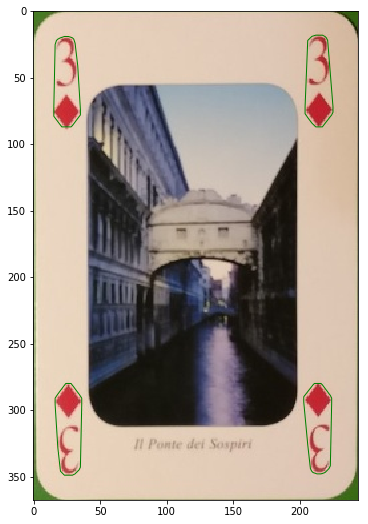

In [86]:
# Test: display a random card
c = cards.get_random(display=True)
print(c)
# Display a random Ace of spades
#_=cards.get_random("As",display=True)

# Generating a scene
We can now generate a scene (= image of the dataset). We are considering here only 2 kinds of scene (but nothing prevents you to add more scenarios):
1. a scene with 2 cards: each card is randomly transformed (scaled, rotated, translated) independantly from the other;
2. a scene with 3 cards : the 3 cards are grouped together (a bit randomly) to form a fan, then the group is randomly transformed.

<img src="img/gen_2_cards.jpg" alt="Generated image with 2 cards" title="Generated image with 2 cards" />
<img src="img/gen_3_cards.jpg" alt="Generated image with 3 cards" title="Generated image with 3 cards" />

### To save bounding boxes annotations in Pascal VOC format 
http://host.robots.ox.ac.uk/pascal/VOC/voc2008/htmldoc/

In [60]:
xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):
    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:            
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)
        


In [131]:
# Scenario with 2 cards:
# The original image of a card has the shape (cardH,cardW,4)
# We first paste it in a zero image of shape (imgH,imgW,4) at position decalX, decalY
# so that the original image is centerd in the zero image
def get_decals(deck):
    decalX = int((imgW - deck.cardW)/2)
    decalY = int((imgH - deck.cardH)/2)
    return (decalX, decalY)

# Scenario with 3 cards : decal values are different
def get_decals_3(deck):
    # decalX3=int(imgW/2)
    decalX3=int((imgW - 200)/2)
    # decalY3=int(imgH/2-cardH)
    decalY3=int(imgH/2 - deck.cardH + 20)
    return (decalX3, decalY3)

def kps_to_polygon(kps):
    """
        Convert imgaug keypoints to shapely polygon
    """
    pts=[(kp.x,kp.y) for kp in kps]
    return Polygon(pts)

def hull_to_kps(hull, decalX, decalY):
    """
        Convert hull to imgaug keypoints
    """
    # hull is a cv2.Contour, shape : Nx1x2
    kps=[ia.Keypoint(x=p[0]+decalX, y=p[1]+decalY) for p in hull.reshape(-1,2)]
    kps=ia.KeypointsOnImage(kps, shape=(imgH,imgW,3))
    return kps

def kps_to_BB(kps):
    """
        Determine imgaug bounding box from imgaug keypoints
    """
    extend=3 # To make the bounding box a little bit bigger
    kpsx=[kp.x for kp in kps.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp.y for kp in kps.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)


# imgaug keypoints of the bounding box of a whole card
def get_card_kp(deck):
    (decalX, decalY) = get_decals(deck)
    return ia.KeypointsOnImage([
        ia.Keypoint(x=decalX, y=decalY),
        ia.Keypoint(x=decalX+deck.cardW, y=decalY),   
        ia.Keypoint(x=decalX+deck.cardW, y=decalY+deck.cardH),
        ia.Keypoint(x=decalX, y=decalY+deck.cardH)
        ], shape=(imgH, imgW, 3))

# imgaug transformation for one card in scenario with 2 cards
transform_1card = iaa.Sequential([
    iaa.Affine(scale=[0.65,1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.25,0.25),"y":(-0.25,0.25)}),
])

# For the 3 cards scenario, we use 3 imgaug transforms, the first 2 are for individual cards, 
# and the third one for the group of 3 cards
trans_rot3 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (20, 30)}),
    iaa.Affine(rotate=(48,55))
])
trans_rot0 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 20)}),
    iaa.Affine(rotate=(38,43))
])
trans_rot1 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 20)}),
    iaa.Affine(rotate=(22,30))
])
trans_rot2 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (0, 5)}),
    iaa.Affine(rotate=(10,15))
])
trans_rots = [trans_rot2, trans_rot1, trans_rot0, trans_rot3]

def get_transform_3cards(deck):
    (decalX, decalY) = get_decals(deck)
    (decalX3, decalY3) = get_decals_3(deck)
    return iaa.Sequential([
        iaa.Affine(translate_px={
            "x": decalX - decalX3,
            "y": decalY - decalY3
        }),
        iaa.Affine(scale=[0.65,1]),
        iaa.Affine(rotate=(-180,180)),
        iaa.Affine(translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)})   
    ])

# imgaug transformation for the background
scaleBg=iaa.Scale({
    "height": imgH,
    "width": imgW,
})

class InvalidPlacement(Exception):
    pass

def augment(img, list_kps, seq, restart=True):
    """
        Apply augmentation 'seq' to image 'img' and keypoints 'list_kps'
        If restart is False, the augmentation has been made deterministic outside the function (used for 3 cards scenario)
    """ 
    # Make sequence deterministic
    while True:
        if restart:
            myseq=seq.to_deterministic()
        else:
            myseq=seq
        # Augment image, keypoints and bbs 
        img_aug = myseq.augment_images([img])[0]
        list_kps_aug = [myseq.augment_keypoints([kp])[0] for kp in list_kps]
        list_bbs = [kps_to_BB(aug) for aug in list_kps_aug[1:]]
        valid=True
        # Check the card bounding box stays inside the image
        for bb in list_bbs:
            if bb is None or int(round(bb.x2)) >= imgW or int(round(bb.y2)) >= imgH or int(bb.x1)<=0 or int(bb.y1)<=0:
                valid=False
                break
        if valid: break
        elif not restart:
            img_aug=None
            break
                
    return img_aug, list_kps_aug, list_bbs

class BBA:  # Bounding box + annotations
    def __init__(self, bb, classname):      
        self.x1 = int(round(bb.x1))
        self.y1 = int(round(bb.y1))
        self.x2 = int(round(bb.x2))
        self.y2 = int(round(bb.y2))
        self.classname = classname

class Scene:
    def __init__(self, bg, scene_type, cards):
        if scene_type == 'fan':
            self.create3CardsScene(bg, cards)
        elif scene_type == 'random':
            self.create2CardsScene(bg, cards)
        else:
            raise Exception('invalid scene type:' + scene_type)

    def create2CardsScene(self, bg, cards):
        num_cards = len(cards)
        kpses = [[hull_to_kps(hull, *get_decals(card.deck)) for hull in card.hulls]
                                    for card in cards]
        
        # Randomly transform 1st card
        deck = cards[0].deck
        (decalX, decalY) = get_decals(deck)
        img = np.zeros((imgH,imgW,4), dtype=np.uint8)
        img[decalY:decalY+deck.cardH, decalX:decalX+deck.cardW, :] = cards[0].img
        cardKP = get_card_kp(deck)
        img, lkps, bbs = augment(img, [cardKP, *kpses[0]], transform_1card)
        self.imgs = [img]
        self.lkpses = [lkps]
        self.bbses = [bbs]
        self.include_corners = [[True] * deck.corners]
        
        # Randomly transform 2nd card. We want that card 2 does not partially cover a corner of 1 card.
        # If so, we apply a new random transform to card 2
        for n, card in enumerate(cards[1:]):
            n += 1
            deck = card.deck
            self.include_corners.append([True] * deck.corners)
            self.imgs.append(None)
            self.lkpses.append(None)
            self.bbses.append(None)
                    
            (decalX, decalY) = get_decals(deck)
            while True:
                include_corners = [list(ll) for ll in self.include_corners]
                
                img = np.zeros((imgH,imgW,4), dtype=np.uint8)
                img[decalY:decalY+deck.cardH, decalX:decalX+deck.cardW, :] = card.img
                cardKP = get_card_kp(deck)
                img, lkps, bbs = augment(img, [cardKP, *kpses[n]], transform_1card)
                
                self.imgs[n] = img
                self.lkpses[n] = lkps
                self.bbses[n] = bbs
                
                invalid = False

                # mainPoly2: shapely polygon of card 2
                mainPoly2 = kps_to_polygon(lkps[0].keypoints[0:4])
                intersect_ratio = 0.1
                
                for j, prev_lkps in enumerate(self.lkpses[:n]):
                    for i in range(1, len(prev_lkps)):
                        # smallPoly1: shapely polygon of one of the hull of previous card
                        smallPoly1 = kps_to_polygon(prev_lkps[i].keypoints[:])
                        a = smallPoly1.area
                        
                        # We calculate area of the intersection of card 1 corner with card 2
                        intersect = mainPoly2.intersection(smallPoly1)
                        ai = intersect.area
                        
                        # If intersection area is small enough, we accept card 2
                        if (a-ai)/a > 1-intersect_ratio:
                            # include this corner if it hasn't already been excluded
                            pass
                            
                        # If intersectio area is not small, but also not big enough, we want apply new transform to card 2
                        elif (a-ai)/a > intersect_ratio:
                            invalid = True
                            break
                        
                        else:
                            include_corners[j][i-1] = False
                
                    if invalid:
                        break

                if not invalid:
                    break
                    
            self.include_corners = include_corners
        
        self.bbses.append([True] * cards[-1].deck.corners)
        self.listbba = []
        for i, bbs in enumerate(self.bbses[:-1]):
            for j, bb in enumerate(bbs):
                if self.include_corners[i][j]:
                    self.listbba.append(BBA(bb, cards[i].name))
            
        self.classes = [card.name for card in cards]
            
        # Construct final image of the scene by superimposing: bg, img1 and img2
        self.bg = scaleBg.augment_image(bg)
        self.masks = []
        self.final = self.bg
        for img in self.imgs:
            mask = np.stack([img[:,:,3]]*3, -1) 
            self.masks.append(mask)
            self.final = np.where(mask, img[:,:,0:3], self.final)       
        
    def create3CardsScene(self, bg, cards):        
        num_cards = len(cards)
        kpses = [[hull_to_kps(hull, *get_decals_3(card.deck)) for hull in card.hulls]
                 for card in cards]

        # Placeholder for img1
        self.imgs = []
        self.lkpses = []
        self.bbses = []
        for i, card in enumerate(cards):
            deck = card.deck
            (decalX3, decalY3) = get_decals_3(deck)
            img = np.zeros((imgH, imgW, 4), dtype=np.uint8)
            img[decalY3:decalY3+deck.cardH, decalX3:decalX3+deck.cardW, :] = card.img
            if i != 0:
                cardKP = get_card_kp(deck)
                img, lkps, bbs = augment(img, [cardKP, *kpses[i]], trans_rots[i-1])
            else:
                lkps = None
                bbs = None
            
            self.imgs.append(img)
            self.lkpses.append(lkps)
            self.bbses.append(bbs)

        new_imgs = [None for _ in range(num_cards)]
        new_lkpses = [None for _ in range(num_cards)]
        transform_3cards = get_transform_3cards(cards[0].deck)
        while True:
            det_transform_3cards = transform_3cards.to_deterministic()
            try:
                for i in range(num_cards-1, 0, -1):
                    _img, _lkps, bbs = augment(self.imgs[i], self.lkpses[i], det_transform_3cards, False)
                    new_imgs[i] = _img
                    new_lkpses[i] = _lkps
                    self.bbses[i] = bbs
                    if _img is None:
                        raise InvalidPlacement('augment failed')
            except InvalidPlacement as e:                   
                continue
            
            cardKP = get_card_kp(cards[0].deck)
            _img, _lkps, self.bbses[0] = augment(self.imgs[0], [cardKP, *kpses[0]], det_transform_3cards, False)
            if _img is None:
                continue
                
            new_imgs[0] = _img
            new_lkpses[0] = _lkps
            break
            
        self.imgs = new_imgs
        self.lkpses = new_lkpses
        
        self.classes = [card.name for card in cards]
        self.listbba = [
            BBA(self.bbses[i][0], card.name)
            for i, card in enumerate(cards)
        ] + \
            [BBA(bbs, cards[num_cards-1].name) for bbs in self.bbses[num_cards-1]] # The last card in the fan has all the corners visible
        
        # Construct final image of the scene by superimposing: bg, img1, img2 and img3
        self.bg = scaleBg.augment_image(bg)
        self.masks = []
        self.final = self.bg
        for img in self.imgs:
            mask = np.stack([img[:,:,3]]*3, -1) 
            self.masks.append(mask)
            self.final = np.where(mask, img[:,:,0:3], self.final)

    def display(self):
        fig, ax = plt.subplots(1, figsize=(8,8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect = patches.Rectangle(
                (bb.x1,bb.y1),
                bb.x2-bb.x1,
                bb.y2-bb.y1,
                linewidth=1,
                edgecolor='b',
                facecolor='none')
            ax.add_patch(rect)
            
    def res(self):
        return self.final
    
    def write_files(self, save_dir, display=False):
        jpg_fn, xml_fn = give_me_filename(save_dir, ["jpg","xml"])
        plt.imsave(jpg_fn, self.final)
        if display:
            print("New image saved in", jpg_fn)
        create_voc_xml(xml_fn, jpg_fn, self.listbba, display=display)

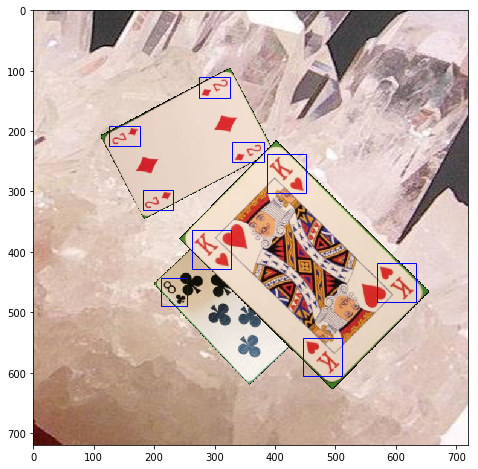

In [67]:
# Test generation of a scene with 3 cards
bg=backgrounds.get_random()
newimg=Scene(bg, 'random', [cards.get_random() for _ in range(3)])
newimg.display()

In [145]:
# Test generation of a scene with 5 cards
bg = backgrounds.get_random()
%lprun -f augment Scene(bg, 'fan', [cards.get_random() for _ in range(5)])

# newimg = Scene(bg, 'fan', [cards.get_random() for _ in range(5)])
# newimg.display()

## Generate the datasets
Typically, you want to generate a training dataset and a validation dataset of different size and different destination directory.
Modify the variable 'nb_cards_to_generate' and 'save_dir' accordingly


### Generation of the scenes

In [133]:
for (n, scene_type) in [(1000, 'random'), (1000, 'fan')]:
    for (set_n, set_type) in [(int(n*0.8), 'train'), (int(n*0.2), 'test')]:
        save_dir = "data/scenes/" + set_type

        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

        print("Generating {} set of {} cards".format(set_type, scene_type))
        for i in tqdm(range(set_n)):
            bg=backgrounds.get_random()
            if scene_type == 'random':
                num_cards = 3
            else:
                num_cards = 5
            newimg=Scene(bg, scene_type, [cards.get_random() for _ in range(num_cards)])
            newimg.write_files(save_dir)


  0%|          | 0/800 [00:00<?, ?it/s]

Generating train set of random cards


  0%|          | 1/200 [00:00<00:22,  8.96it/s]

Generating test set of random cards


  0%|          | 1/800 [00:00<02:31,  5.27it/s]

Generating train set of fan cards


  0%|          | 1/200 [00:00<00:31,  6.30it/s]

Generating test set of fan cards


100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


## In case you want to train YOLO with the generated datasets
YOLO cannot directly exploit the Pascal VOC annotations files. You need to convert the xml files in txt files accordingly to the syntax explained here: https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects
The script 'convert_voc_yolo.py' makes this conversion and also generates the txt file that contains all the images of the dataset

In [218]:
!mkdir -p data/scenes/val
!rm -rf data/scenes/val/*
!cp -r data/scenes/train/* data/scenes/val
!cp -r data/scenes/test/* data/scenes/val
!python convert_voc_yolo.py data/scenes/train data/cards.names data/val.txt
#!python convert_voc_yolo.py data/scenes/val data/cards.names data/val.txt
#python convert_voc_yolo.py data/scenes/train data/cards.names data/train.txt

['ah', 'kh', 'qh', 'jh', 'th', '9h', '8h', '7h', '6h', '5h', '4h', '3h', '2h', 'ad', 'kd', 'qd', 'jd', 'td', '9d', '8d', '7d', '6d', '5d', '4d', '3d', '2d', 'ac', 'kc', 'qc', 'jc', 'tc', '9c', '8c', '7c', '6c', '5c', '4c', '3c', '2c', 'as', 'ks', 'qs', 'js', 'ts', '9s', '8s', '7s', '6s', '5s', '4s', '3s', '2s'] 52
100
200
300
400
